<a href="https://colab.research.google.com/github/lamyse1/Recommender-Systems/blob/main/Practical_Exercise_Building_a_Content_Based_Recommender_System_Using_Text_Data_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade gensim
!pip install numpy==1.23.5 --upgrade

import os
os.kill(os.getpid(), 9)


In [1]:
import os
import re
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

import gensim.downloader as api


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# Download GloVe vectors (only needed once)
!wget -q https://nlp.stanford.edu/data/glove.6B.zip

# Unzip the GloVe archive
!unzip -q glove.6B.zip


^C
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [23]:

# ------------------- 1. Load Pretrained Word Embeddings -------------------
# Load GloVe embeddings
import pandas as pd
print("Loading GloVe Model...")
glove_df = pd.read_csv('glove.6B.300d.txt', sep=" ",
                       quoting=3, header=None, index_col=0)
glove_model = {key: value.values for key, value in glove_df.T.items()}



Loading GloVe Model...


In [2]:
word2vecModel = api.load("word2vec-google-news-300")


[==================================================] 100.0% 1662.8/1662.8MB downloaded


# Generate Sentence Embeddings
In natural language processing (NLP), sentence embeddings are vector representations that capture the semantic meaning of a whole sentence. Unlike word embeddings, which represent individual words, sentence embeddings attempt to represent the meaning of an entire sentence or phrase.

One straightforward method for generating sentence embeddings is by averaging the word embeddings of the words in the sentence. This method assumes that the meaning of a sentence can be approximated by combining the meanings of the individual words that it contains. Here's how the function get_sentence_vector() works to generate sentence embeddings:

The function takes a sentence as input, tokenizes it into words, and looks up the corresponding word embeddings for each word in a pre-trained model (such as Word2Vec, GloVe, or FastText).
The embeddings of the words are summed up, and the resulting vector is divided by the total number of words found in the model to get an average representation of the sentence.
If any word in the sentence is not present in the embedding model, it is ignored, and the remaining words contribute to the final sentence embedding.
This method provides a simple yet effective way to represent the semantic meaning of a sentence and can be used in various NLP tasks, including similarity comparison, clustering, or feeding into machine learning models for classification or regression.

Below is the implementation of the function that generates a sentence embedding by averaging word vectors.

Explore how changing the dimensionality of word embeddings (e.g., 50, 100, 300) affects the quality of recommendations.

In [24]:
# ------------------- Generate Sentence Embeddings -------------------
def get_sentence_vector(sentence, model, embedding_size=300):
    """Get sentence embedding by averaging word vectors."""
    words = nltk.word_tokenize(sentence.lower())
    sentence_vector = np.zeros((embedding_size,))
    count = 0

    for word in words:
        if word in model:
            sentence_vector += model[word]
            count += 1

    return sentence_vector / count if count > 0 else sentence_vector


# Pre-Processing

In [25]:
# Load the dataset
df = pd.read_csv("Rec_sys_content.csv", quotechar='"', escapechar="\\")

# Extract the 3rd column (product description)
product_descriptions = df.iloc[:, 2].dropna().astype(str).tolist()

# Print a few descriptions to verify
print(product_descriptions[:5])  # Print the first 5 descriptions


['New unique design, great gift.High quality plastic material.Clips over the back of the device to protect the back &amp; sides from bumps and scratches.Printed using a process called sublimation, high quality image which will last for years!| New unique design, great gift. High quality plastic material. Clips over the back of the device to protect the back &amp; sides from bumps and scratches. Printed using a process called sublimation, high quality image which will last for years! ', 'Rounded rectangular cat-eye reading glasses. These frames feature a deep burgundy color on the face of the frame with crystal interior, as well as crystal temple detail and yellow, turqoise and black marbled colors on the inside of the temple arms. The standard hinges provide durability and the TR-90 con struction allows for some flex making these glasses very sturdy and perfect for every day use!| Always custom made to your individual order specifications in our FDA Listed Lab with the remarkable Optic

In [26]:

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

def get_sentence_vector(sentence, model, embedding_size=300):
    words = word_tokenize(sentence.lower())
    sentence_vector = np.zeros((embedding_size,))
    count = 0
    for word in words:
        if word in model:
            sentence_vector += model[word]
            count += 1
    return sentence_vector / count if count > 0 else sentence_vector


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [28]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# Compute Embeddings
In this step, we compute the embeddings for each product description using pre-trained models like Word2Vec and GloVe. These models generate vector representations for words, and by averaging the word embeddings in a description, we obtain a vector that represents the entire product description. This enables us to measure the semantic similarity between different products based on their descriptions.

Below is the code to compute the sentence embeddings for each product description using Word2Vec and GloVe:



In [29]:
word2vec_embeddings = np.array([get_sentence_vector(desc, word2vecModel) for desc in product_descriptions])
glove_embeddings = np.array([get_sentence_vector(desc, glove_model) for desc in product_descriptions])


# Compute Similarity Scores
This function calculates the similarity between a given product description and all other product descriptions using cosine similarity. It retrieves the most similar products based on their embeddings. To ensure diversity in the recommendations, it also checks for duplicate descriptions and excludes them from the top recommendations. The function then returns the top N most similar products based on their cosine similarity scores.

Below is the code to compute and return the most similar products:

In [30]:
# ------------------- Compute Similarity Scores -------------------
def get_most_similar(query_index, embeddings, descriptions, method="Embedding Model", top_n=10):
    """Compute the most similar products based on cosine similarity."""
    similarities = cosine_similarity([embeddings[query_index]], embeddings)[0]
    sorted_indices = np.argsort(similarities)[::-1][1:]  # Exclude itself

    # Set to track unique descriptions
    unique_descriptions = set()

    # Select top_n most similar products
    top_indices = []
    top_similarities = []
    for idx in sorted_indices:
        if descriptions[idx] not in unique_descriptions:
            unique_descriptions.add(descriptions[idx])
            top_indices.append(idx)
            top_similarities.append(similarities[idx])
        if len(top_indices) == top_n:
            break

    print(f"\n🔹 Top {top_n} Recommendations for: '{descriptions[query_index]}' using {method}")
    for idx, similarity in zip(top_indices, top_similarities):
        print(f"   ✅ {descriptions[idx]} (Similarity: {similarity:.2f})")

    # Return the top_n recommendations' embeddings and descriptions
    top_embeddings = embeddings[top_indices]
    top_descriptions = [descriptions[idx] for idx in top_indices]
    return top_embeddings, top_descriptions

# Task: Visualize the top 10 recommended embeddings in 2D using PCA (Principal Component Analysis).

Instructions:

1- Truncate Labels:

The descriptions of the products can be long. To make the plot readable, truncate the labels to a maximum length (max_label_length).
If the label exceeds this length, append ... at the end. If it doesn't exceed, keep the label as is.
Apply PCA:

2- Use PCA (Principal Component Analysis) to reduce the embeddings (which are high-dimensional vectors) into 2D space. This will help us visualize the embeddings in 2D.
The method fit_transform() can be used to reduce the dimensionality of the embeddings to two components.
Create a Scatter Plot:

3- Use the plt.scatter() function to plot the 2D PCA components on the x and y axes.
Each point on the scatter plot represents one of the top 10 recommended product embeddings.
Annotate the Points:

4- Annotate each point on the scatter plot with its truncated description so you can identify which product corresponds to each point.
Use the plt.annotate() function for this. Ensure the annotations do not overlap by adjusting their position.
Customize Plot:

5- Add a title with plt.title(), and label the x and y axes with plt.xlabel() and plt.ylabel().


In [33]:
# ------------------- Visualizing Top 10 Recommended Embeddings -------------------
def plot_embeddings(embeddings, descriptions, title, max_label_length=30):
    """Visualize the embeddings of the top recommended products."""

    # 1. Truncate descriptions
    truncated_labels = [
        desc if len(desc) <= max_label_length else desc[:max_label_length - 3] + "..."
        for desc in descriptions
    ]

    # 2. Apply PCA to reduce to 2D
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    # 3. Create the scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], marker='o')

    # 4. Annotate each point
    for i, label in enumerate(truncated_labels):
        plt.annotate(label, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=9, ha='right', va='bottom')

    # 5. Customize plot
    plt.title(f"{title} Top 10 Recommended Embeddings in 2D")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.show()



📝 Running recommendations using Word2Vec embeddings:

🔹 Top 10 Recommendations for: 'New unique design, great gift.High quality plastic material.Clips over the back of the device to protect the back &amp; sides from bumps and scratches.Printed using a process called sublimation, high quality image which will last for years!| New unique design, great gift. High quality plastic material. Clips over the back of the device to protect the back &amp; sides from bumps and scratches. Printed using a process called sublimation, high quality image which will last for years! ' using Word2Vec
   ✅ Hybrid Case Information: Brand new hard plastic case combined with soft rubber gel silicone skin cover. Hybrid case is a molded perfect-fit to your phone. Double the protection both front and back hard cover. Protects your phone against any scratch, bump, finger marks, and dirt. High quality silicone that is resistant to shock and has a great grip. Custom cutout design, giving you total access to all fu

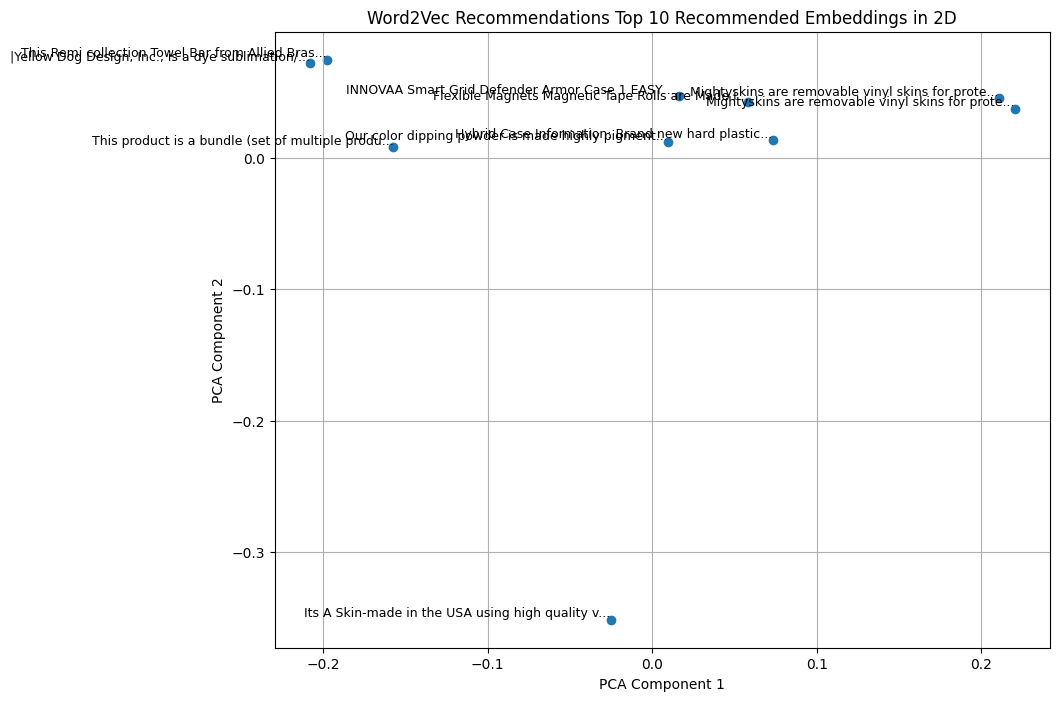


📝 Running recommendations using GloVe embeddings:

🔹 Top 10 Recommendations for: 'New unique design, great gift.High quality plastic material.Clips over the back of the device to protect the back &amp; sides from bumps and scratches.Printed using a process called sublimation, high quality image which will last for years!| New unique design, great gift. High quality plastic material. Clips over the back of the device to protect the back &amp; sides from bumps and scratches. Printed using a process called sublimation, high quality image which will last for years! ' using GloVe
   ✅ |Yellow Dog Design, Inc., is a dye sublimation/heat transfer printing company specializing in the design and manufacture of a unique line of pet collars and leads, as well as Equine fashions, in their local NC facility. This line is passionate about the product as evidenced by the 5 awesome canines that come to work with us everyday, 4 Labs, and 1 Dachshund. They are our models and some of the best product te

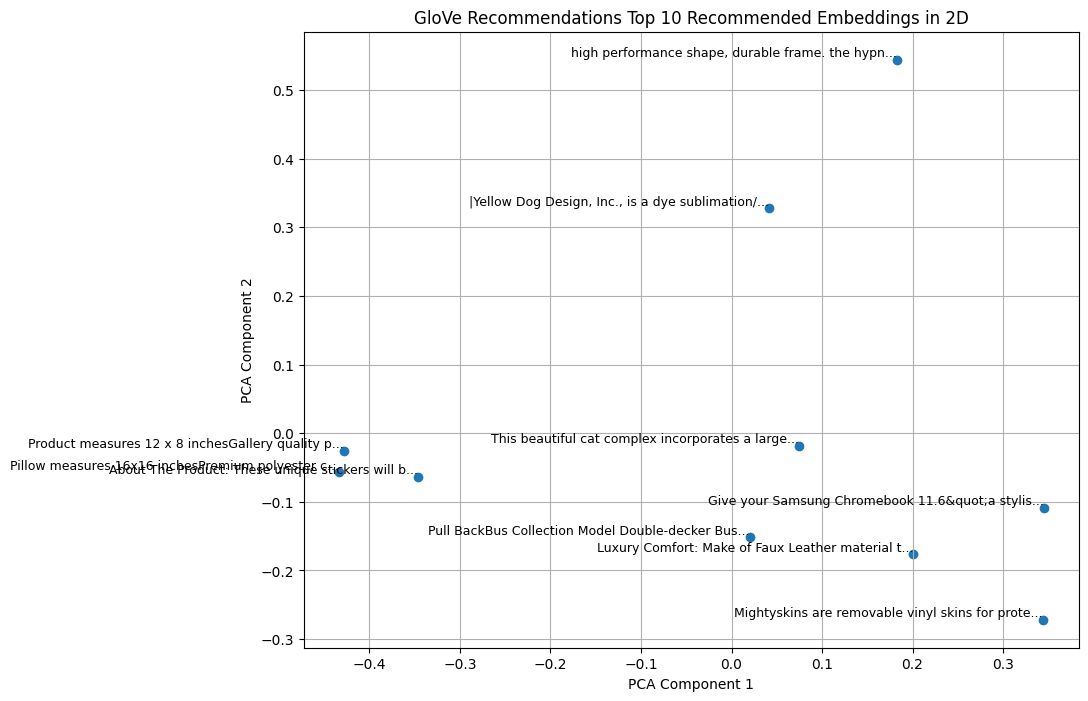

In [34]:
# ------------------- Running for Multiple Models -------------------
def process_and_plot(query_product, product_descriptions, embeddings_dict, top_n=10):
    """Process and plot the top recommendations for multiple models (Word2Vec, GloVe)."""
    for method, embeddings in embeddings_dict.items():
        print(f"\n📝 Running recommendations using {method} embeddings:")
        top_embeddings, top_descriptions = get_most_similar(query_product, embeddings, product_descriptions, method, top_n)
        plot_embeddings(top_embeddings, top_descriptions, f"{method} Recommendations", max_label_length=50)


embeddings_dict = {
    "Word2Vec": word2vec_embeddings,
    "GloVe": glove_embeddings
}

# Choose a product to base recommendations on
query_product = 0  # Choose first product for example

# Process and visualize for all models
process_and_plot(query_product, product_descriptions, embeddings_dict, top_n=10)